<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/Dive_Prediction_1D_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Seabird Diving Behaviour with GPS data

Supervized Learning with Deep Networks


## Connecting Drive and Github

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
%cd drive/My\ Drive/BirdDL

/content/drive/My Drive/BirdDL


## Data Formatting

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
import datetime
import random
import pickle

import trip

In [4]:
# connect to database
conn = sqlite3.connect('/content/drive/My Drive/data/seabirdbank.db')

In [5]:
request = "SELECT DISTINCT lon, lat FROM fieldwork WHERE place='Pescadores'"
colony = pd.read_sql_query(request, conn)
colony = colony.values
colony

array([[-77.264, -11.773]])

In [6]:
request = "SELECT \
            trip.id as trip, gps.datetime, gps.lon, gps.lat\
            FROM gps \
            INNER JOIN trip ON gps.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# substr(bird.fieldwork,1,1) = 'P'

gps = pd.read_sql_query(request, conn)
gps

,trip,datetime,lon,lat
0,P1108_4_SV_T1,2008-11-25 13:00:35,-77.264128,-11.773317
1,P1108_4_SV_T1,2008-11-25 13:00:36,-77.264118,-11.773235
2,P1108_4_SV_T1,2008-11-25 13:00:37,-77.264098,-11.773152
3,P1108_4_SV_T1,2008-11-25 13:00:38,-77.264113,-11.773060
4,P1108_4_SV_T1,2008-11-25 13:00:39,-77.264142,-11.772955
...,...,...,...,...
839803,P1113_50_SV_T2,2013-11-25 05:23:26,-77.264832,-11.773701
839804,P1113_50_SV_T2,2013-11-25 05:23:27,-77.264862,-11.773664
839805,P1113_50_SV_T2,2013-11-25 05:23:28,-77.264900,-11.773705
839806,P1113_50_SV_T2,2013-11-25 05:23:29,-77.264931,-11.773739


In [7]:
# check duplicated datetime in GPS trip
idx = gps.index[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]
idx_drop = [idx[i] for i in range(0, len(idx), 2)]
gps = gps.drop(idx_drop)

In [8]:
gps[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]

,trip,datetime,lon,lat


In [9]:
request = "SELECT \
            trip.id as trip, tdr.datetime, tdr.pressure \
            FROM tdr \
            INNER JOIN trip ON tdr.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# WHERE substr(bird.fieldwork,1,1) = 'P' 

tdr = pd.read_sql_query(request, conn)
tdr

,trip,datetime,pressure
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29
...,...,...,...
1086337,P1113_50_SV_T2,2013-11-25 05:23:26,-0.94
1086338,P1113_50_SV_T2,2013-11-25 05:23:27,-0.94
1086339,P1113_50_SV_T2,2013-11-25 05:23:28,-0.94
1086340,P1113_50_SV_T2,2013-11-25 05:23:29,-0.94


In [10]:
tdr['datetime'] = pd.to_datetime(tdr['datetime'], format='%Y-%m-%d %H:%M:%S')
gps['datetime'] = pd.to_datetime(gps['datetime'], format='%Y-%m-%d %H:%M:%S')

In [11]:
df = pd.merge(tdr, gps, on=['trip', 'datetime'], how='left')
df

,trip,datetime,pressure,lon,lat
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955
...,...,...,...,...,...
1086337,P1113_50_SV_T2,2013-11-25 05:23:26,-0.94,-77.264832,-11.773701
1086338,P1113_50_SV_T2,2013-11-25 05:23:27,-0.94,-77.264862,-11.773664
1086339,P1113_50_SV_T2,2013-11-25 05:23:28,-0.94,-77.264900,-11.773705
1086340,P1113_50_SV_T2,2013-11-25 05:23:29,-0.94,-77.264931,-11.773739


In [12]:
# check NaN and fill with interpolations
[i for i, x in enumerate(df['lon'].isna()) if x]


df['lon'] = df['lon'].interpolate(method='polynomial', order=2)
df['lat'] = df['lat'].interpolate(method='polynomial', order=2)

In [13]:
len(df.trip.unique())

185

In [ ]:
# threshold = 1
# path_folder = "./trajectory/"

# for t in df.trip.unique():
    
#     path_file = path_folder + t
#     df_trip = df[df.trip == t]
    
#     bias = np.median(df_trip.pressure.values)
  
#     plt.figure(figsize=(9, 3))

#     plt.subplot(1, 2, 1)
#     plt.plot(df_trip.datetime.values, df_trip.pressure.values)
#     plt.plot(df_trip.datetime.values, [threshold+bias for i in range(len(df_trip))], color = 'orange')

#     plt.subplot(1, 2, 2)
#     plt.plot(df_trip.lon.values, df_trip.lat.values)
#     plt.scatter(df_trip.lon.values[df_trip.pressure-bias > threshold], \
#                 df_trip.lat.values[df_trip.pressure-bias > threshold], c = 'orange')
    
#     plt.savefig(path_file)
#     plt.close()

In [14]:
bad_trip = ['P1111_9_SV_T1', 'P1111_13_SV_T6', 'P1111_41_SV_T2', 'P1111_46_SV_T5', 'P1111_52_SV_T1',
            'P1112_4_SV_T2', 'P1112_26_SV_T5', 'P1112_36_SV_T1', 'P1112_36_SV_T2', 'P1113_41_SV_T3',
           'P1113_50_SV_T2']

no_loop = ['P1112_26_SV_T1', 'P1112_26_SV_T2', 'P1112_26_SV_T3', 'P1112_26_SV_T4']

In [15]:
### remove bad data
idx = df.index[[(t in bad_trip or t in no_loop) for t in df.trip]]
df = df.drop(idx)

In [16]:
len(df.trip.unique())

170

## Trip Statistics

In [17]:
df_trip = df[df.trip == 'P1108_4_SV_T1']
df_trip

,trip,datetime,pressure,lon,lat
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955
...,...,...,...,...,...
6622,P1108_4_SV_T1,2008-11-25 14:50:57,-0.29,-77.264097,-11.773710
6623,P1108_4_SV_T1,2008-11-25 14:50:58,-0.29,-77.264223,-11.773817
6624,P1108_4_SV_T1,2008-11-25 14:50:59,-0.26,-77.264307,-11.773860
6625,P1108_4_SV_T1,2008-11-25 14:51:00,-0.22,-77.264363,-11.773875


In [18]:
# create trip
t = trip.Trip(df_trip)
threshold = 1

# add variable
t.add_step()
t.add_cap()
t.add_direction()
t.add_dive(threshold)
t.df['cos_cap'] = np.cos(t.df.cap)
t.df['sin_cap'] = np.sin(t.df.cap)

# standardize variable
t.standardize(('step', 'direction'))
t.standardize_minmax(('lon', 'lat'))

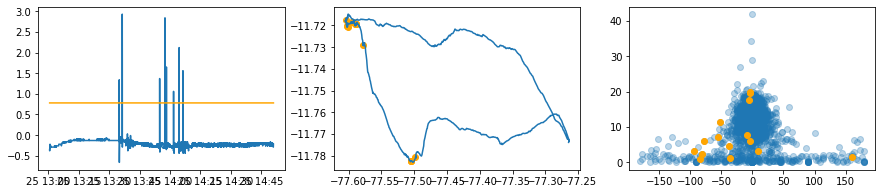

In [19]:
t.plot()

In [20]:
t.get_duration()

Timedelta('0 days 01:50:26')

In [21]:
t.get_distance()

88.1484595608965

In [22]:
t.df.head()

,trip,datetime,pressure,lon,lat,step,cap,direction,dive,cos_cap,sin_cap,step_std,direction_std,lon_std_mm,lat_std_mm
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.999801,0.143444
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235,9.192428,6.808074,NaN,0,0.865380,0.501117,-1.114452,NaN,0.999830,0.144644
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152,9.492498,13.273123,6.465048,0,0.760475,0.649367,-1.033105,0.316087,0.999889,0.145858
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060,10.370362,350.931311,-22.341812,0,0.600183,-0.799863,-0.795125,-1.099954,0.999845,0.147204
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955,12.107480,344.870108,-6.061203,0,0.761557,-0.648098,-0.324208,-0.299658,0.999760,0.148740


## Dive Prediction

In [23]:
%%time

trajs = []
radius = 500
n = 1
for k in df.trip.unique():
    df_trip = df[df.trip == k]
    
    t = trip.Trip(df_trip)
    # add variables
    t.add_dive(threshold)
    t.add_step()
    t.add_cap()
    t.add_direction()
    t.df['cos_cap'] = np.cos(t.df.cap)
    t.df['sin_cap'] = np.sin(t.df.cap)

    # standardized trajectories
    t.standardize(('step', 'direction'))
    t.standardize_minmax(('lon', 'lat'))

    trajs.append(t.df)
    
    IPython.display.clear_output(wait=True)
    print('Trip [{}/{}]'.format(n, len(df.trip.unique())))
    n+=1

Trip [170/170]
CPU times: user 21 s, sys: 348 ms, total: 21.3 s
Wall time: 21.2 s


In [24]:
trajs[0]

,trip,datetime,pressure,lon,lat,dive,step,cap,direction,cos_cap,sin_cap,step_std,direction_std,lon_std_mm,lat_std_mm
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999801,0.143444
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235,0,9.192428,6.808074,NaN,0.865380,0.501117,-1.114452,NaN,0.999830,0.144644
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152,0,9.492498,13.273123,6.465048,0.760475,0.649367,-1.033105,0.316087,0.999889,0.145858
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060,0,10.370362,350.931311,-22.341812,0.600183,-0.799863,-0.795125,-1.099954,0.999845,0.147204
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955,0,12.107480,344.870108,-6.061203,0.761557,-0.648098,-0.324208,-0.299658,0.999760,0.148740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6622,P1108_4_SV_T1,2008-11-25 14:50:57,-0.29,-77.264097,-11.773710,0,15.773785,194.809616,17.804082,0.999524,0.030867,0.669693,0.873473,0.999892,0.137695
6623,P1108_4_SV_T1,2008-11-25 14:50:58,-0.29,-77.264223,-11.773817,0,18.176315,229.059760,34.250144,-0.962016,0.272994,1.320996,1.681902,0.999523,0.136130
6624,P1108_4_SV_T1,2008-11-25 14:50:59,-0.26,-77.264307,-11.773860,0,10.329409,242.394637,13.334877,-0.881389,-0.472392,-0.806227,0.653783,0.999277,0.135500
6625,P1108_4_SV_T1,2008-11-25 14:51:00,-0.22,-77.264363,-11.773875,0,6.326643,254.697607,12.302970,-0.973984,-0.226616,-1.891339,0.603058,0.999113,0.135281


In [25]:
test_trajs_idx = np.random.randint(0, len(df.trip.unique()), 30)

test_trajs = [trajs[i] for i in test_trajs_idx]
train_trajs = [trajs[i] for i in range(len(df.trip.unique())) if i not in test_trajs_idx]

## Analysis for better hyper-parametrization

- resolution
- typology of dives
- ...
